<a href="https://colab.research.google.com/github/Woracle/FASTAI_CQC_Reports/blob/master/20210505_CQCReports_FASTAI_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# set_up notebook
# run on google colab to access the GPU processing.
!pip install utils
!pip install fastcore
!pip install fastai==2.3.0

import fastai
from fastai.text.all import *
from fastcore.foundation import L
from utils import *

     |████████████████████████████████| 61kB 5.0MB/s 
     |████████████████████████████████| 194kB 7.8MB/s 
     |████████████████████████████████| 776.8MB 22kB/s 
     |████████████████████████████████| 12.8MB 35kB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [2]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score
import requests
from collections import OrderedDict
import json

In [3]:
#set up folders 
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
root_dir = 'drive/My Drive/Colab Notebooks/'

# Here is where you'll need to update to point to any specific folders you create. We only use these to store the API reports. 
base_dir = root_dir + 'files'
reports_dir = base_dir + "/Reports"

Mounted at /content/drive


In [45]:
# Create functions
# Functions to connect to CQC API and retreive Inspection Reports.

# First step is to get the location ids
def get_location_ids(records):
    r = requests.get("https://api.cqc.org.uk/public/v1/locations?page=1&perPage="+str(records))   
    if r.status_code == 200:
        txt = json.loads(r.content)
        df = pd.DataFrame(txt["locations"])
    else:
        return("Http request not successful")
    return(df)

# 
def get_location_details(ids):
  req_string = "https://api.cqc.org.uk/public/v1/locations/" + ids
  df = pd.DataFrame()

  for i, string in enumerate(req_string):
    r = requests.get(string)
    txt = json.loads(r.content)
    row = pd.json_normalize(txt)
    df = df.append(row, ignore_index=True)
    
  return(df)

# get report text
def get_report_text(reportid):

  req_string = "https://api.cqc.org.uk/public/v1/reports/" + reportid
  r = requests.get(req_string, headers = {"Accept":"text/plain"})
  report_txt = r.content

  return(report_txt)

In [46]:
# Use the API functions to extract data from CQCs API
loc_df = get_location_ids(10000)
deets_df = get_location_details(loc_df.iloc[:,0])
reports_df = deets_df.dropna(subset = ["currentRatings.overall.reportLinkId"])
reports_df["text"] = reports_df.apply(lambda row: get_report_text(row["currentRatings.overall.reportLinkId"]), axis = 1)
# file tends to be stored as byte string (i.e. prefixed with b) below decodes the byte string.
reports_df['text'] = reports_df['text'].str.decode(encoding="utf-8", errors="ignore")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [74]:
# Save out a pickle so we don't have to keep hitting the API. 
#reports_df.to_pickle(reports_dir+"/20210507 Reports Data.pkl")
reports_df = pd.read_pickle(reports_dir+"/20210507 Reports Data.pkl")

In [75]:
# Here we just take a small subset for speed. Colab has run time limits and to run
# on the full data set would take too long. I've kept the large dataset in the process
# incase you have access to better GPU compute options. 
reports_df.reset_index()
reports_df = reports_df.iloc[0:400,:]
reports_df.shape

(400, 57)

# Creating a language Model with Transfer Learning (FastAI)
Now that we have our data we can use the free text in the inspection reports to train a language model. 

Creating Language Models from scratch is time consuming, requires huge amounts of data/compute and can often require us to create additional text files designed around teaching specific "rules" to the language. 

It is often much better to take a langauge model that already understands the basic concepts of the language you are working in (i.e. English) and then tweak it to understand the specific domain you are working on. That way you don't have to teach it English, you only have to teach the model the subject matter / domain. This use of a general model and tweaking it to your domain is called Transfer Learning and it can really speed up the process of developing language models.

FastAI provides some really convienient wrappers around the different stages of the process making it really simple to apply transfer learning. There are several, high and mid level APIs (read the docs) but for simplicity we are going to show the following:

  - Dataloaders - used for loading the data read to be fed into our model.
  - Learners - used for training the model. 

Lets use our reports text to build ontop of a pre-build lanaguage model

# The humble DataBlock
First lets create a DataBlock a sort of template for how we want to read in our data

Notice the following:
  - we are using TextBlock.from_df because our format is a pandas df and we are reading text. There are a number of different block types so you can load from files, you can even add custom functions to extract dataas you need. 
  - secondly we have is_lm = TRUE this means it is going to try and classify
The next word in sequence as opposed to requiring us to provide a specific classification to the model. (just a conveient wrapper internally it is still a classification task i.e. given this squence what is the next word)
  - We use get_items to specify where in our dataframe to look for the text. 


In [78]:
# first build the data block
reports_datab = DataBlock(blocks=TextBlock.from_df('text', is_lm = True),
                    get_items=ColReader('text'))

The next step is to use our "template" datablock as instructions to read in our data. 

# Data loaders
To do this within the FASTAI api we use a dataloader. bs = batch size and seq_len = sequence length. These arguments just support chunking up the text. I probably need to explore the impact of tweaking these further but for now they are not particularly important to generating our language model.

The key thing is the dataloader handles creating the training test and validation sets from the data provided. 

In [79]:
# next use the data block 
reports_dls_lm = reports_datab.dataloaders(reports_df, bs = 128, seq_len = 80)

Lets take a look at at the first two pieces of text we've loaded. There are few automated preprocessing steps that have been taken, mostly tokenisation and some string replacements. The string replacements are indicated by the xx prefix. so xxbos symbolised the begining of a string xxunk is a replacement for very low frequency words. xxrep indicates a repeating pattern etc. 

In [80]:
reports_dls_lm.show_batch(max_n = 2)

,text,text_
0,xxbos 1 xxmaj progressive xxmaj mews xxmaj inspection report 30 xxmaj january 2017 \n xxmaj homes xxunk xxmaj care xxmaj limited \n xxmaj progressive xxmaj mews \n xxmaj inspection report \n xxmaj xxunk xxmaj road \n xxmaj eight xxmaj xxunk xxmaj green \n xxmaj xxunk \n xxmaj essex \n xxup xxunk xxunk \n xxmaj tel : xxunk \n xxmaj date of inspection visit : \n 16 xxmaj november 2016 \n xxmaj date of publication : \n 30 xxmaj january 2017,1 xxmaj progressive xxmaj mews xxmaj inspection report 30 xxmaj january 2017 \n xxmaj homes xxunk xxmaj care xxmaj limited \n xxmaj progressive xxmaj mews \n xxmaj inspection report \n xxmaj xxunk xxmaj road \n xxmaj eight xxmaj xxunk xxmaj green \n xxmaj xxunk \n xxmaj essex \n xxup xxunk xxunk \n xxmaj tel : xxunk \n xxmaj date of inspection visit : \n 16 xxmaj november 2016 \n xxmaj date of publication : \n 30 xxmaj january 2017 \n
1,"prior to being sent to a dental laboratory \n and before treatment was completed . \n xxmaj the practice had procedures to reduce the possibility of \n xxmaj legionella or other bacteria developing in the water \n systems , in line with a risk assessment . xxmaj all \n recommendations had been actioned and records of water \n testing and dental unit water line management were in \n place . \n xxmaj we saw cleaning schedules for the premises .","to being sent to a dental laboratory \n and before treatment was completed . \n xxmaj the practice had procedures to reduce the possibility of \n xxmaj legionella or other bacteria developing in the water \n systems , in line with a risk assessment . xxmaj all \n recommendations had been actioned and records of water \n testing and dental unit water line management were in \n place . \n xxmaj we saw cleaning schedules for the premises . xxmaj"


# Training a Language Model
Now that we've looked at the text lets start to train our model. 

The first thing we need to do is to create a "learner". FASTAI has a built in language learner so we can easily build our language model. in this case we provide it with 3 key arguments:

  - First we give it our "loaded" data loader
  - Secondly we give it a "model" here we give it a prebuilt pytorch model based on LSTMs trained on wikipedia. However, you can contruct your own architecture's using pytorch and put that here. 
  - thirdly metrics a dict of methods to output for you the user to see performance



In [81]:
learn = language_model_learner(
    reports_dls_lm, AWD_LSTM, drop_mult= 0.3,
    metrics = [accuracy, Perplexity()]).to_fp16()

To begin with we can run a a single pass over the model only training the top layer this helps the align the final prediction layer to the pre-build model. 

In [82]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.111483,3.884032,0.309200,48.619869,45:52


We can then unfreeze the the lower levels of the model and train the whole thing. Because we aligned the top layer retraining the whole model should retain much of the understanding encoded in the pre-built model only updating where it can to improve predictions. 

In [83]:
learn.unfreeze()
learn.fit_one_cycle(3, 2e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.566002,2.292500,0.509435,9.899653,46:10
1,2.073258,2.036916,0.559299,7.666928,45:37
2,1.863051,1.995046,0.568259,7.352542,45:23


By taking this staggard approach to updating the pre-trained model to our new domain, we can ensure that lots of the general learning we've taken from the prebuilt model is retained and should allow us train a decent langauge model that is trained to our domain but able to generalise well.

Now we have our model we can have a little play. Through doing this we can get a sense of what the model "thinks" and whether it understands our domain. 

In [84]:
TEXT = "The service must"
N_words = 50
N_sentences = 3
preds = [learn.predict(TEXT, N_words, temperature= 0.75) for _ in range(N_sentences)]

print('\n'.join(preds))

The service must make the Mental Capacity Act 2005 ( mca ) . It introduces 
 legal requirements to make sure that people who lack the capacity to make decisions about their 
 care and treatment can only be deprived of their liberty to receive care and treatment when
The service must have been met by the registered manager 
 The Registered Manager and Registered Manager had overall responsibility for the 
 management and management of the service . 
 This was a large amount of time for people receiving the service . The 

The service must enable people to be involved in decisions about their care 
 and treatment . The registered manager confirmed that this would be taken into 
 consideration . 
 Are services well - led ? 
 We found that this practice was providing well - led care in


Now that we've build our model and are happy with it, we can now save the model. For our use case (i.e. classifiers) we don't want the full model but instead we want everything but the last layer (i.e. the word prediction layer). What we can do is detatch the last layer and save that model. This is referred to in the documentation as the "encoder".

In [89]:
# set the model path and then save
learn.path = Path(reports_dir)
learn.save_encoder("reports_lm")

# Using our language model

Now that we have a language model that "understands" CQC reports we can use this model for different tasks. In our case we looking to generate a number of text classifiers looking at CQC reports. The value here is that we can train the classifiers ontop of the language model. in the interest of time we will only build one classifier identifying whether the location had what we consider a good (Good or outstanding) or bad (RI or inadequate) but this template serves as a model that allows us to build any number of classifiers. 

Lets start by creating the DataBlock and loader for our classifier. Which will try and classifier the overall rating of the report based on the text. 

In [147]:
# Now we've trained the language model we can look to train on more of our original data.
# be cause we are only doing one prediction per record it is much faster than language modelling which goes
# through each piece of text in a moving window. 
# So lets reimport our original dataset
reports_df = pd.read_pickle(reports_dir+"/20210507 Reports Data.pkl")
# To simplify again we can create a binary classification task
# Good and outstanding = good
reports_df["isgood"] = reports_df["currentRatings.overall.rating"].isin(["Good", "Outstanding"])

In [148]:
# lets start with creating the datablock and loading the data
clas_block = DataBlock(
    blocks = (TextBlock.from_df('text', vocab = reports_dls_lm.vocab), CategoryBlock),
    get_x = ColReader('text'),
    get_y = ColReader('isgood'),
    splitter = RandomSplitter(0.2)
)
# and loading the data
dls_clas = clas_block.dataloaders(reports_df, bs = 128, seq_len = 80)

# we can take a quick peak at the data being fed into the classifier
dls_clas.show_batch(max_n = 3)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,text,category
0,"xxbos xxmaj this report describes our judgement of the quality of care at this location . xxmaj it is based on a combination of what we \n found when we inspected and a review of all information available to xxup cqc including information given to us from \n patients , the public and other organisations \n xxmaj ratings \n xxmaj overall rating for this location xxmaj good xxrep 3 – \n xxmaj are services safe ? xxmaj good xxrep 3 – \n xxmaj are services effective ? xxmaj good xxrep 3 – \n xxmaj are services caring ? xxmaj good xxrep 3 – \n xxmaj are services responsive ? xxmaj good xxrep 3 – \n xxmaj are services well - led ? xxmaj good xxrep 3 – \n xxmaj mental xxmaj health xxmaj act responsibilities and xxmaj mental xxmaj capacity xxmaj act and xxmaj deprivation of xxmaj liberty \n xxmaj",True
1,"xxbos xxmaj this report describes our judgement of the quality of care at this location . xxmaj it is based on a combination of what we \n found when we inspected and a review of all information available to xxup cqc including information given to us from \n patients , the public and other organisations \n xxmaj ratings \n xxmaj overall rating for this location xxmaj good xxrep 3 – \n xxmaj are services safe ? xxmaj good xxrep 3 – \n xxmaj are services effective ? xxmaj good xxrep 3 – \n xxmaj are services caring ? xxmaj good xxrep 3 – \n xxmaj are services responsive ? xxmaj good xxrep 3 – \n xxmaj are services well - led ? xxmaj good xxrep 3 – \n xxmaj mental xxmaj health xxmaj act responsibilities and xxmaj mental xxmaj capacity xxmaj act and xxmaj deprivation of xxmaj liberty \n xxmaj",True
2,"xxbos xxmaj this report describes our judgement of the quality of care at this location . xxmaj it is based on a combination of what we \n found when we inspected and a review of all information available to xxup cqc including information given to us from \n patients , the public and other organisations \n xxmaj ratings \n xxmaj overall rating for this location xxmaj good xxrep 3 – \n xxmaj are services safe ? xxmaj good xxrep 3 – \n xxmaj are services effective ? xxmaj good xxrep 3 – \n xxmaj are services caring ? xxmaj good xxrep 3 – \n xxmaj are services responsive ? xxmaj good xxrep 3 – \n xxmaj are services well - led ? xxmaj good xxrep 3 – \n xxmaj overall summary \n xxmaj xxunk xxmaj hospital is operated by xxmaj nuffield xxmaj health . xxmaj the \n hospital has 49",True


Once we have the loader we can build the learner. You'll notice we use the same model architecture (AWD_LSTM) this means we can update the weights with our pretrained language model.

In [149]:
learner_clas = text_classifier_learner(dls_clas,
                                       AWD_LSTM,
                                       drop_mult=0.5,
                                       metrics = [accuracy, Perplexity()]).to_fp16()

So let set the path for our learner (so it can find our pretrained encoder we saved earlier) and then load that encoder. This updates all the AWD_LSTM based on the reports_language model

In [150]:
learner_clas.path = Path(reports_dir)
learner_clas.load_encoder("reports_lm")

Like before when we first load a model everything apart fomr the head is frozen. We can start by training the head, to classify our reports for one cycle. This gives it a baseline understanding of how to use the language model to predict the text

In [151]:
learner_clas.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,0.390697,0.395719,0.894910,1.485452,03:06


We can then unfreeze the final 2 layers and train again. 

In [152]:
learner_clas.freeze_to(-2)
learner_clas.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,0.290725,0.192228,0.934319,1.211947,03:11
1,0.252473,0.193395,0.933498,1.213362,03:11


We can continue to expirment in working backwards but as this is a demo we'll stop here and just unfreeze the whole model and then one last run.

In [153]:
learner_clas.unfreeze()
learner_clas.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,0.212819,0.145079,0.945813,1.156131,03:45
1,0.192938,0.138248,0.953202,1.148260,03:45


Lets save our classifier. This model can be loaded and used to classify new data.

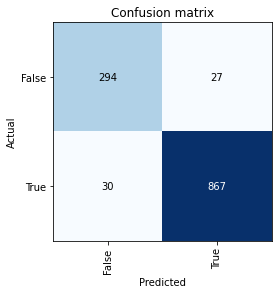

In [154]:
interp = fastai.text.all.ClassificationInterpretation.from_learner(learner_clas)
interp.plot_confusion_matrix()

In [155]:
learner_clas.save("reports_sector_classifier")

Path('drive/My Drive/Colab Notebooks/files/Reports/models/reports_sector_classifier.pth')

In [156]:
learner_clas.predict(item= "This service didn't protect people's safety, it negelected to treat people with dignity and smelled funny")

('False', tensor(0), tensor([0.9215, 0.0785]))

# Why is this so good
For a single text classifier this two step approach might not seem valuable but the ability to focus once on training a single high quality understanding of the language in reports and then reuse that to quickly build effective classifiers scales well.

Building tens of classifiers that are generally high perfoming with minimal tuning is not an unachieveable task if we investing in developing a good intial language model. 

It also means improvements in the language model can improve performance across multiple classifiers, giving us two places we and seek to improve performance. Once in the language model and again in the final classifier.  

By using FASTAI all of these steps can be achieved relatively easily with decent performance. 